In [14]:
# загрузка библиотек
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import orbit
from orbit.models import KTR
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.backtest import BackTester
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования предсказаний
from orbit.utils.params_tuning import grid_search_orbit #для подбора оптимальных параметров
import arviz as az
from orbit.eda import eda_plot
from orbit.utils.dataset import load_iclaims

In [15]:
summary = pd.read_csv('summary.csv', encoding='1251')
summary

,order_month,orders,mean_quantity,total_revenue,avg_order_price,hour
0,1,2,3.00,105.25,52.62,2015-01-01 11:00:00
1,1,7,2.43,263.25,37.61,2015-01-01 12:00:00
2,1,10,3.30,577.20,57.72,2015-01-01 13:00:00
3,1,7,2.14,246.00,35.14,2015-01-01 14:00:00
4,1,7,2.00,230.25,32.89,2015-01-01 15:00:00
...,...,...,...,...,...,...
4176,12,12,1.92,396.15,33.01,2015-12-31 19:00:00
4177,12,5,3.40,278.50,55.70,2015-12-31 20:00:00
4178,12,2,3.50,113.20,56.60,2015-12-31 21:00:00
4179,12,1,1.00,20.25,20.25,2015-12-31 22:00:00


In [16]:
summary['hour'] = pd.to_datetime(summary['hour'], infer_datetime_format = True)

C:\Users\Katerina\AppData\Local\Temp\ipykernel_2060\3871992200.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  summary['hour'] = pd.to_datetime(summary['hour'], infer_datetime_format = True)


In [17]:
summary['hour'] = pd.to_datetime(summary['hour'])

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot:xlabel='hour', ylabel='orders'>

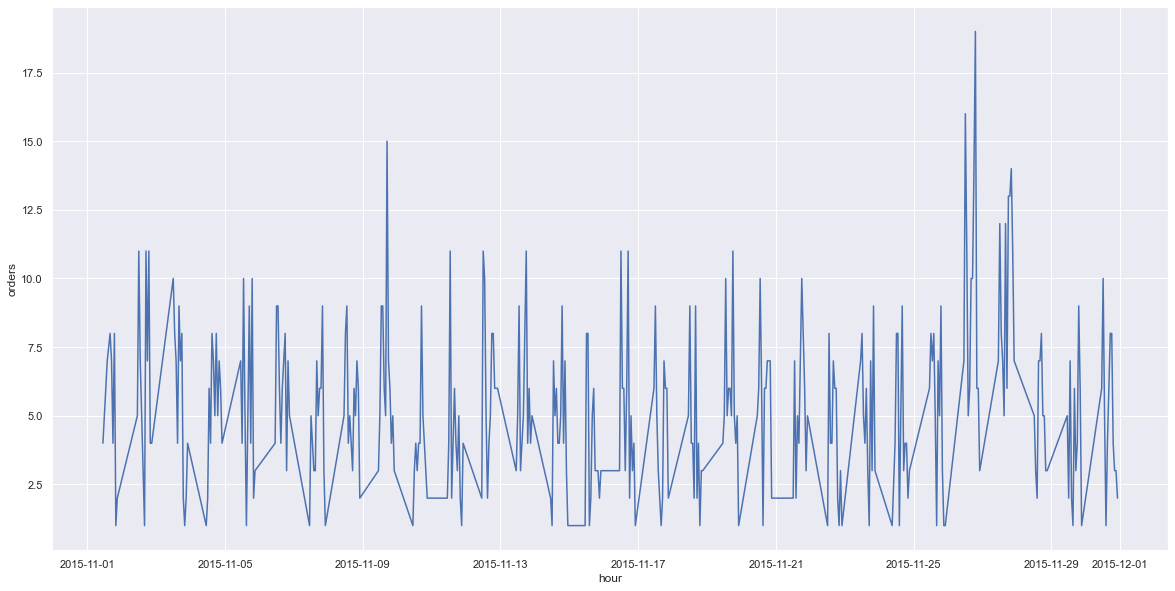

In [18]:
sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(x='hour', y='orders', data=summary[summary['order_month']==11])

In [19]:
summary_11 = summary[summary['order_month']==11]
summary_11

,order_month,orders,mean_quantity,total_revenue,avg_order_price,hour
3497,11,4,1.50,95.75,23.94,2015-11-01 11:00:00
3498,11,5,3.20,243.75,48.75,2015-11-01 12:00:00
3499,11,6,2.50,253.50,42.25,2015-11-01 13:00:00
3500,11,7,2.14,208.95,29.85,2015-11-01 14:00:00
3501,11,8,2.25,295.25,36.91,2015-11-01 16:00:00
...,...,...,...,...,...,...
3839,11,8,1.88,254.00,31.75,2015-11-30 18:00:00
3840,11,4,2.50,174.00,43.50,2015-11-30 19:00:00
3841,11,3,2.00,86.25,28.75,2015-11-30 20:00:00
3842,11,3,1.00,61.75,20.58,2015-11-30 21:00:00


In [35]:
# построение модели DLT  с алгоритмом stan-map
dlt = DLT(response_col="orders", #название колонки с метрикой
          date_col="hour", #название колонки с датами-временем
          seasonality=24*30, #длина периода сезонности
          estimator="stan-map",
          n_bootstrap_draws=1000) #количество сэмплов бутстрапа для доверительного интервала

2024-02-08 11:13:59 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [36]:
dlt.fit(summary_11)

c:\ProgramData\Anaconda3\lib\site-packages\orbit\forecaster\forecaster.py:288: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


ValueError: operands could not be broadcast together with shapes (347,) (720,) 

In [22]:
future_df = dlt.make_future_df(periods=24*7) #горизонт будет 30 дней - то есть 30 раз по 24 часа
future_df.sample(10)

,hour
85,2016-02-24 22:00:00
104,2016-03-14 22:00:00
39,2016-01-09 22:00:00
157,2016-05-06 22:00:00
108,2016-03-18 22:00:00
51,2016-01-21 22:00:00
149,2016-04-28 22:00:00
75,2016-02-14 22:00:00
27,2015-12-28 22:00:00
41,2016-01-11 22:00:00


In [23]:
predicted_df = dlt.predict(df=future_df)
predicted_df.head(5)

,hour,prediction_5,prediction,prediction_95
0,2015-12-01 22:00:00,2.049632,6.251644,10.231422
1,2015-12-02 22:00:00,2.241613,6.252374,10.118919
2,2015-12-03 22:00:00,0.163793,4.307813,8.618477
3,2015-12-04 22:00:00,0.347417,4.591957,8.577077
4,2015-12-05 22:00:00,0.095428,4.254762,8.262750
5,2015-12-06 22:00:00,2.225680,6.254566,10.518998
6,2015-12-07 22:00:00,0.523861,4.786077,8.482419
7,2015-12-08 22:00:00,2.208908,6.256694,10.710781
8,2015-12-09 22:00:00,2.151840,6.136021,10.328415
9,2015-12-10 22:00:00,0.674714,4.916365,9.240787


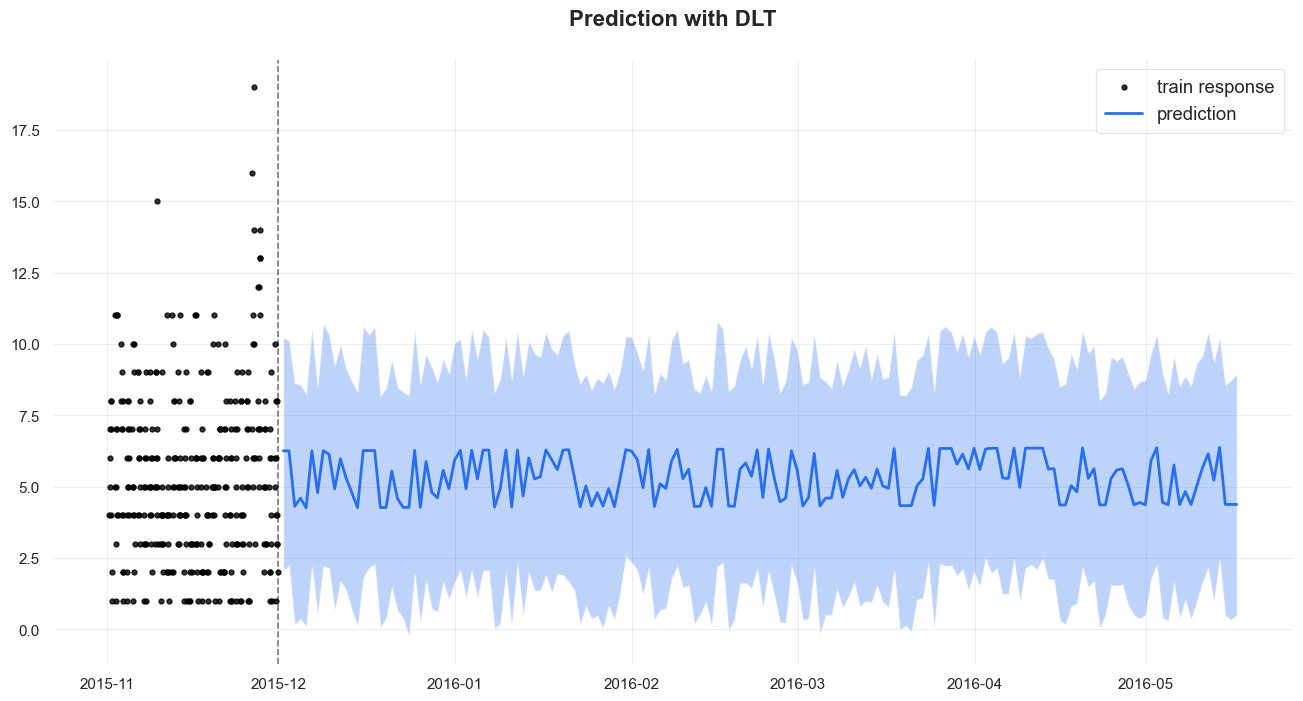

In [24]:
_ = plot_predicted_data(summary_11, predicted_df, "hour", 'orders', title='Prediction with DLT')

In [26]:
dlt.fit(summary_11)

c:\ProgramData\Anaconda3\lib\site-packages\orbit\forecaster\forecaster.py:288: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


In [30]:
future_df = dlt.make_future_df(periods=24*7*2) #горизонт будет 30 дней - то есть 30 раз по 24 часа
future_df.sample(10)

,hour
131,2016-04-10 22:00:00
107,2016-03-17 22:00:00
225,2016-07-13 22:00:00
191,2016-06-09 22:00:00
80,2016-02-19 22:00:00
105,2016-03-15 22:00:00
30,2015-12-31 22:00:00
63,2016-02-02 22:00:00
178,2016-05-27 22:00:00
86,2016-02-25 22:00:00


In [31]:
predicted_df = dlt.predict(df=future_df)
predicted_df.head(5)

,hour,prediction_5,prediction,prediction_95
0,2015-12-01 22:00:00,-0.266522,4.492134,9.665185
1,2015-12-02 22:00:00,0.317705,4.959841,9.403424
2,2015-12-03 22:00:00,0.001027,4.594182,9.176759
3,2015-12-04 22:00:00,-0.214460,4.523141,9.251058
4,2015-12-05 22:00:00,0.160639,4.685951,9.465294


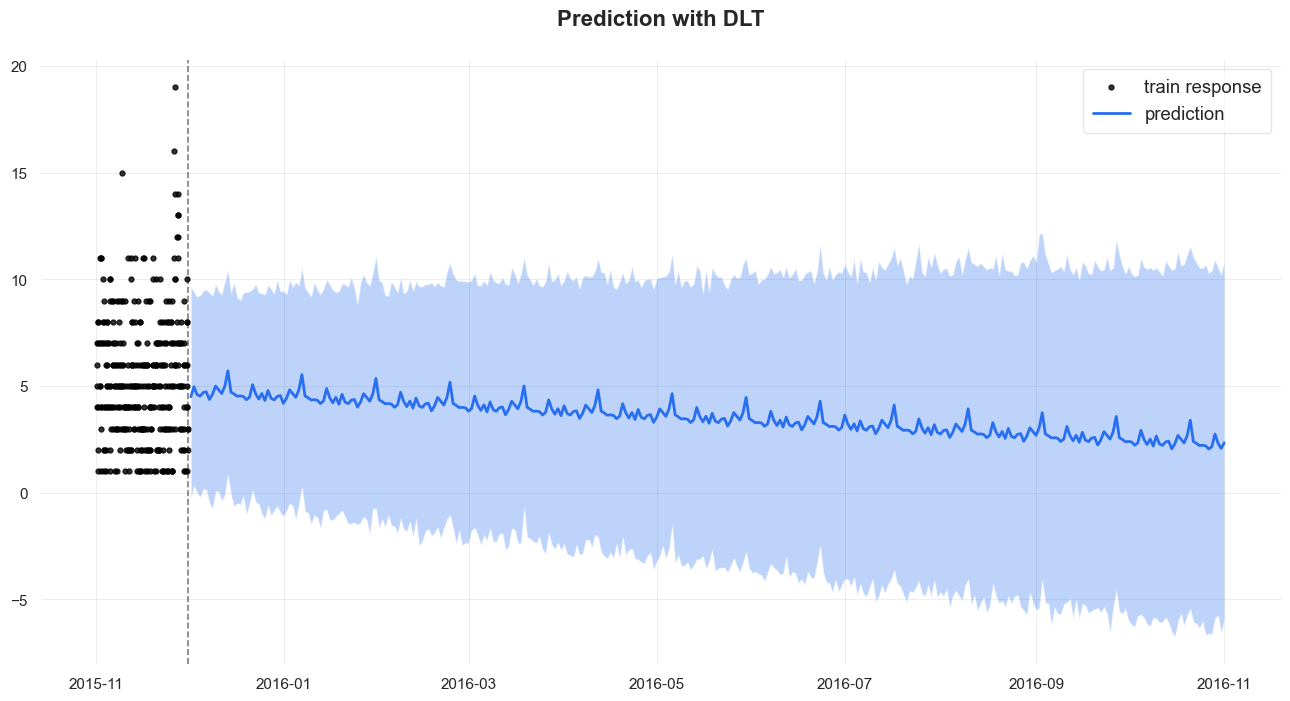

In [32]:
_ = plot_predicted_data(summary_11, predicted_df, "hour", 'orders', title='Prediction with DLT')

In [25]:
# построение модели DLT  с алгоритмом stan-map
dlt = DLT(response_col="orders", #название колонки с метрикой
          date_col="hour", #название колонки с датами-временем
          seasonality=24, #длина периода сезонности
          estimator="stan-map",
          n_bootstrap_draws=1000) #количество сэмплов бутстрапа для доверительного интервала

2024-02-08 11:11:44 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
